In [ ]:
import torch
import numpy as np
import torch.nn as nn
from torch.autograd import Variable
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [ ]:


class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.hidden_layer1 = nn.Linear(2,5)
        self.hidden_layer2 = nn.Linear(5,5)
        self.hidden_layer3 = nn.Linear(5,5)
        self.hidden_layer4 = nn.Linear(5,5)
        self.hidden_layer5 = nn.Linear(5,5)
        self.output_layer = nn.Linear(5,1)

    def forward(self, x,t):
        inputs = torch.cat([x,t],axis=1) # combined two arrays of 1 columns each to one array of 2 columns
        layer1_out = torch.sigmoid(self.hidden_layer1(inputs))
        layer2_out = torch.sigmoid(self.hidden_layer2(layer1_out))
        layer3_out = torch.sigmoid(self.hidden_layer3(layer2_out))
        layer4_out = torch.sigmoid(self.hidden_layer4(layer3_out))
        layer5_out = torch.sigmoid(self.hidden_layer5(layer4_out))
        output = self.output_layer(layer5_out) ## For regression, no activation is used in output layer
        return output

In [ ]:

net = Net()
net = net.to(device)
mse_cost_function = torch.nn.MSELoss()
optimizer = torch.optim.Adam(net.parameters())

In [ ]:

def f(x,t, net):
    u = net(x,t)
    u_x = torch.autograd.grad(u.sum(), x, create_graph=True)[0]
    u_xx = torch.autograd.grad(u_x.sum(), x, create_graph=True)[0]
    u_t = torch.autograd.grad(u.sum(), t, create_graph=True)[0]
    u_tt = torch.autograd.grad(u_t.sum(), t, create_graph=True)[0]
    pde = u_xx + u_tt
    return pde

In [ ]:
# generate testing data
# using 

V_0 = 1
a=2

x_bc = np.random.uniform(low=0.0, high=a, size=(500,1))
t_bc = np.random.uniform(low=0.0, high=a, size=(500,1))

u_bc = (2*V_0)/np.pi * np.arctan((np.sin(np.pi * t_bc / a) / (np.sinh(np.pi * x_bc / a))))

In [ ]:
# run through training
iterations = 15000
previous_validation_loss = 99999999.0
for epoch in range(iterations):
    optimizer.zero_grad()
    
    pt_x_bc = Variable(torch.from_numpy(x_bc).float(), requires_grad=False).to(device)
    pt_t_bc = Variable(torch.from_numpy(t_bc).float(), requires_grad=False).to(device)
    pt_u_bc = Variable(torch.from_numpy(u_bc).float(), requires_grad=False).to(device)
    
    net_bc_out = net(pt_x_bc, pt_t_bc) # output of u(x,t)
    mse_u = mse_cost_function(net_bc_out, pt_u_bc)
    
    x_collocation = np.random.uniform(low=0.0, high=100.0, size=(500,1))
    t_collocation = np.random.uniform(low=0.0, high=100.0, size=(500,1))
    all_zeros = np.zeros((500,1))
    
    
    pt_x_collocation = Variable(torch.from_numpy(x_collocation).float(), requires_grad=True).to(device)
    pt_t_collocation = Variable(torch.from_numpy(t_collocation).float(), requires_grad=True).to(device)
    pt_all_zeros = Variable(torch.from_numpy(all_zeros).float(), requires_grad=False).to(device)
    
    f_out = f(pt_x_collocation, pt_t_collocation, net) # output of f(x,t)
    mse_f = mse_cost_function(f_out, pt_all_zeros)
    
    loss = mse_u + mse_f
    
    
    loss.backward() 
    optimizer.step() 

    with torch.autograd.no_grad():
    	print(epoch,"Traning Loss:",loss.data)

Streaming output truncated to the last 5000 lines.
10000 Traning Loss: tensor(0.0022, device='cuda:0')
10001 Traning Loss: tensor(0.0023, device='cuda:0')
10002 Traning Loss: tensor(0.0022, device='cuda:0')
10003 Traning Loss: tensor(0.0022, device='cuda:0')
10004 Traning Loss: tensor(0.0022, device='cuda:0')
10005 Traning Loss: tensor(0.0022, device='cuda:0')
10006 Traning Loss: tensor(0.0022, device='cuda:0')
10007 Traning Loss: tensor(0.0021, device='cuda:0')
10008 Traning Loss: tensor(0.0021, device='cuda:0')
10009 Traning Loss: tensor(0.0145, device='cuda:0')
10010 Traning Loss: tensor(0.0022, device='cuda:0')
10011 Traning Loss: tensor(0.0024, device='cuda:0')
10012 Traning Loss: tensor(0.0022, device='cuda:0')
10013 Traning Loss: tensor(0.0022, device='cuda:0')
10014 Traning Loss: tensor(0.0022, device='cuda:0')
10015 Traning Loss: tensor(0.0040, device='cuda:0')
10016 Traning Loss: tensor(0.0033, device='cuda:0')
10017 Traning Loss: tensor(0.0022, device='cuda:0')
10018 Traning

(10000, 1)
(100, 100)


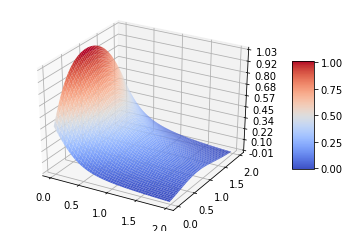

In [ ]:
# plot predicted

from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
from matplotlib import cm
from matplotlib.ticker import LinearLocator, FormatStrFormatter
import numpy as np

fig = plt.figure()
ax = fig.gca(projection='3d')

x=np.arange(0,a,0.02)
t=np.arange(0,a,0.02)
ms_x, ms_t = np.meshgrid(x, t)

x = np.ravel(ms_x).reshape(-1,1)
t = np.ravel(ms_t).reshape(-1,1)


pt_x = Variable(torch.from_numpy(x).float(), requires_grad=True).to(device)
pt_t = Variable(torch.from_numpy(t).float(), requires_grad=True).to(device)
pt_u = net(pt_x,pt_t)
u=pt_u.data.cpu().numpy()
ms_u = u.reshape(ms_x.shape)

surf = ax.plot_surface(ms_x,ms_t,ms_u, cmap=cm.coolwarm,linewidth=0, antialiased=True)

ax.zaxis.set_major_locator(LinearLocator(10))
ax.zaxis.set_major_formatter(FormatStrFormatter('%.02f'))

fig.colorbar(surf, shrink=0.5, aspect=5)

plt.show()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: RuntimeWarning: divide by zero encountered in true_divide
  after removing the cwd from sys.path.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: RuntimeWarning: invalid value encountered in true_divide
  after removing the cwd from sys.path.
/usr/local/lib/python3.7/dist-packages/mpl_toolkits/mplot3d/art3d.py:304: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  self._segments3d = np.asanyarray(segments)


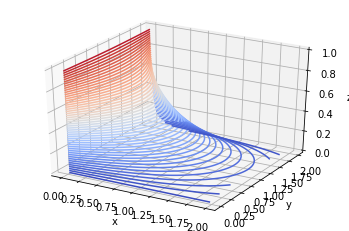

In [ ]:
# plot actual
x = np.arange(0,a,0.02)
y = np.arange(0,a,0.02)
X, Y = np.meshgrid(x, y)
Z = (2*V_0)/np.pi * np.arctan((np.sin(np.pi * Y / a) / (np.sinh(np.pi * X / a))))

fig = plt.figure()
ax = plt.axes(projection='3d')
ax.contour3D(X, Y, Z, 50, cmap=cm.coolwarm)
ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_zlabel('z')

plt.show()

Code based on https://github.com/nanditadoloi/PINN/blob/main/solve_PDE_NN.ipynb